# Week 6 - Neural Networks
<i>MSDS422</i>

---

You will continue work on the Digit Recognition problem in Kaggle.com this week.   As in Assignment 5, we will assess classification performance accuracy and processing time. Python TensorFlow / Keras should be used for Assignment 6. (If you experience difficulty installing TensorFlow, Python scikit-learn may be used as an alternative for Assignment 6.)
The Benchmark Experiment

Tested neural network structures should be explored within a benchmark experiment, a factorial design with at least two levels on each of two experimental factors (at least a 2x2 completely crossed design).  You will build your models on train.csv and submit your forecasts for test.csv to Kaggle.com, providing your name and user ID for each experimental trial..

An example experiment could include two values for the number of nodes per inner layer and two values for the number of inner layers. Various machine learning hyperparameter settings may be used.

In summary, this assignment asks you to fit a number of neural networks, comparing processing time and performance across experimental treatments. Processing time will be recorded for the fitting on the train.csv.  Kaggle.com accuracy scores will be reported for all benchmarks.  

## Management Question

Suppose you are a financial institution evaluating machine learning technologies for optical character recognition. Initial testing is on the MNIST digits. What can you conclude from your benchmark study? Which neural network typology and hyperparameter settings would you recommend as being the most trustworthy?

## Results:

I chose to do my benchmark evaluation on two prameters; number of hidden layers and nodes per layer. For all 4 models I used 30 epochs. I followed the example provided in Geron and used a Sequential TensorFlow model. To make life easier I actually created a function that included all of the steps; building the model, timing it, producing a graph of the results, predicting on the test set, and packing it up for submission to Kaggle. The table below show the results of all 4 tests:

|Model #| Number of Hidden Layers | Nodes per Layer | Processing Time | Training Accuracy | Test Accuracy| Kaggle Score |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 2 | 20 | 00:51.9 | 96.26% | 94.99% | 94.742% |
| 2 | 2 | 100 | 01:08.4 | 98.51% | 96.67% | 96.514% |
| 3 | 4 | 20 | 00:53.1 | 97.01% | 95.32% | 94.585% |
| 4 | 4 | 100 | 01:09.6 | 99.61% | 96.75% | 96.600% |

As you can see the last model performed the best. Clearly though we started to overfit the model towards the end because we see that the training accuracy nears 100% however the test accuracy stagnates. The charts and model output allow us to see that. It was also interesting to see that increasing the number of hidden layers had very minimal effects on the time to run the model however the number of nodes dramatically increases it. While it costed us time, increasing the nodes had the best effect on increasing the accuracy. 

**Management Answer:** 
Based on this benchmark study I found the number of nodes per hidden layer to have the best effect on increasing accuracy as compared to number of hidden layers. This study is limited because there are many other things that could be tested or changed that will affect accuracy. A more thorough study should be conducted to include more parameters/models.


---

## Appendix and Code 


## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Data Prep
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import time
import datetime
#Modeling
import tensorflow as tf
from tensorflow import keras
#Validation
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Comfirming Tensorflow works, I couldn't get this to run on my computer. 
# It works here in google colab, hooray!
tf.__version__

'2.2.0-rc4'

In [0]:
# Ensuring the models are repeatable
tf.random.set_seed = '1776'

## Importing Data

In [5]:
# installing the kaggle package
!pip install -U -q kaggle

# Making a new directory for kaggle
!mkdir -p ~/.kaggle

# Uploading my kaggle.json api key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gallagh4","key":"c768cc31a82d10dd6a7d53a0a741bc3c"}'}

In [0]:
# copying my api key to my new kaggle folder
!cp kaggle.json ~/.kaggle/

# Hiding my API key
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
# Grabbing dataset from kaggle
!kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 35.1MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 99.2MB/s]
 76% 7.00M/9.16M [00:00<00:00, 71.6MB/s]
100% 9.16M/9.16M [00:00<00:00, 84.1MB/s]


In [0]:
# reading in datasets
df_train = pd.read_csv('/content/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_val = pd.read_csv('/content/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

In [9]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Prep

In [0]:
# Splitting the training into training and test sets
# Also scaling the data by dividing by 255
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label'], axis= 1)/255,
                                                    df_train.loc[:,'label'], 
                                                    train_size = 0.8,
                                                    random_state = 1776)

In [0]:
# Scaling the validation data
df_val = df_val/255

In [0]:
# Defining function for running the tensorflow model

def tfmodel(hidden_layers, nodes, model_num):

  # Starting a timer
  start = datetime.datetime.now()

  # Building Model
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten())
  for num in range(0,hidden_layers):
    model.add(keras.layers.Dense(nodes, activation = 'relu'))
  model.add(keras.layers.Dense(10, activation = 'softmax'))

  #Compiling the model
  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'sgd',
                metrics = ['accuracy'])

  # Training and evaluating the model
  history = model.fit(X_train,y_train, epochs = 30, validation_data = (X_test, y_test))

  # End time
  end = datetime.datetime.now()
  print("Elapsed Time: ",end-start)

  # Making a graph to view the results over the 30 epoches
  pd.DataFrame(history.history).plot(figsize = (8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()

  ################## Prepping Submission for Kaggle ###############################################

  # Transforming and predicting on Kaggle's test set
  final_predictions = model.predict_classes(df_val)

  # Packaging submission up
  ImageId = df_val.index+1
  my_solution = pd.DataFrame(final_predictions, ImageId, columns = ['label'])
  my_solution.to_csv("submission{}.csv".format(model_num), index_label = ["ImageId"])



## Modeling

Model 1: 2 hidden layers, 20 nodes

In [20]:
tfmodel(2,20,1)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1050/1050 [==============================] - 2s 2ms/step - loss: 1.1736 - accuracy: 0.6476 - val_loss: 0.5675 - val_accuracy: 0.8352
Epoch 2/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.4578 - accuracy: 0.8683 - val_loss: 0.3967 - val_accuracy: 0.8867
Epoch 3/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3586 - accuracy: 0.8956 - val_loss: 0.3383 - val_accuracy: 0.9029
Epoch 4/30
1050/1050 [==============================] - 2s 2ms/step - loss: 

Tensorflow Model 2: 2 hidden layers, 100 nodes

In [25]:
tfmodel(2,100,2)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1050/1050 [==============================] - 2s 2ms/step - loss: 0.8218 - accuracy: 0.7886 - val_loss: 0.4140 - val_accuracy: 0.8840
Epoch 2/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3509 - accuracy: 0.8988 - val_loss: 0.3224 - val_accuracy: 0.9067
Epoch 3/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2924 - accuracy: 0.9150 - val_loss: 0.2839 - val_accuracy: 0.9194
Epoch 4/30
1050/1050 [==============================] - 2s 2ms/step - loss: 

Tensorflow Model 3: 4 hidden layers, 20 nodes

In [27]:
tfmodel(4,20,3)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1050/1050 [==============================] - 2s 2ms/step - loss: 1.6780 - accuracy: 0.4231 - val_loss: 0.8082 - val_accuracy: 0.7375
Epoch 2/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.5738 - accuracy: 0.8223 - val_loss: 0.4327 - val_accuracy: 0.8714
Epoch 3/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3787 - accuracy: 0.8836 - val_loss: 0.3771 - val_accuracy: 0.8848
Epoch 4/30
1050/1050 [==============================] - 2s 2ms/step - loss: 

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1050/1050 [==============================] - 3s 3ms/step - loss: 1.0469 - accuracy: 0.6839 - val_loss: 0.4432 - val_accuracy: 0.8701
Epoch 2/30
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3556 - accuracy: 0.8955 - val_loss: 0.3207 - val_accuracy: 0.9080
Epoch 3/30
1050/1050 [==============================] - 3s 2ms/step - loss: 0.2765 - accuracy: 0.9180 - val_loss: 0.2615 - val_accuracy: 0.9230
Epoch 4/30
1050/1050 [==============================] - 3s 2ms/step - loss: 

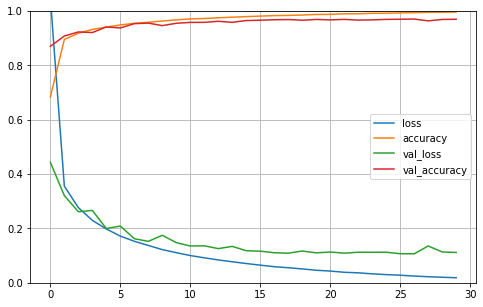

In [32]:
tfmodel(4,100,4)

## Submitting to Kaggle

In [30]:
# Submitting to kaggle
!kaggle competitions submit -c digit-recognizer -f submission4.csv -m "Week 6: Sub 4 - TF(4 layers, 100 nodes)"

100% 208k/208k [00:00<00:00, 513kB/s]
Successfully submitted to Digit Recognizer